<a href="https://colab.research.google.com/github/lphohmann/DL_microbial_gene_classifier/blob/main/1D_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setting everything up

In [4]:
#hide
!pip install fastai --upgrade
#!pip install -Uqq fastbook --upgrade
#!pip install torchtext==0.8.1

     |████████████████████████████████| 194kB 5.1MB/s 
     |████████████████████████████████| 61kB 5.3MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [5]:
import numpy as np

In [6]:
#hide
#import fastbook
#fastbook.setup_book()

In [7]:
#hide
#import fastai
from fastai import *
from fastai.vision.all import *
#from fastai.text.all import *
#from fastai.callback import *

In [8]:
# mount google drive to access files and set the correct working
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd drive/MyDrive/ColabNotebooks/DL_project/
!pwd

Mounted at /content/drive
/content/drive/MyDrive/ColabNotebooks/DL_project
/content/drive/MyDrive/ColabNotebooks/DL_project


# Define functions required for creating the Datablock

In [9]:
# get the training and validation datasets

In [10]:
# defining functions required for building the DataBlock
# one hot encoding function
from sklearn.preprocessing import OneHotEncoder
def OH_enc(seq: str):
    # get the categories into array
    cats = ['K', 'D', 'N', 'E', 'R', 'A', 'T', 'L', 'I', 'Q', 'C', 'F', 'G', 'W', 'M', 'S', 'H', 'P', 'V', 'Y']
    cat_array = np.array(sorted(cats), ndmin=1) #
    # get seq into array
    trunc_seq = seq[:300] # truncate sequences longer than 300 
    seq_array = np.array(list(trunc_seq))
    #one hot encode the sequence
    onehot_encoder = OneHotEncoder(categories=[cat_array],sparse=False,handle_unknown='ignore')
    onehot_encoded_seq = onehot_encoder.fit_transform(seq_array.reshape(len(seq_array), 1))
    return np.transpose(onehot_encoded_seq)

# zero padding function
def pad_along_axis(array: np.ndarray, target_length: int, axis: int = 0):
    pad_size = target_length - array.shape[axis]
    if pad_size <= 0:
        return array
    npad = [(0, 0)] * array.ndim
    npad[axis] = (0, pad_size)
    return np.pad(array, pad_width=npad, mode='constant', constant_values=0)

# combine in one function
def main_item_tfms(seq): # added -> None because the tensor shape later is 1,2820 and i think it should be 20,2820
    enc_seq = OH_enc(seq)
    pad_encseq_array = pad_along_axis(enc_seq,300,1)
    return pad_encseq_array 

In [11]:
# get_x and y by specifying column in dataframe
def get_y(r): return r['Knum']
def get_x(r): 
    return main_item_tfms(r['Seq']) # apply the one hot encoding and padding function

In [12]:
# read in my data from which training and validation set will be created
trainval = pd.read_csv('trainval.csv', low_memory=False)

In [13]:
# CategoryBlock -> typetfm: categorize, batchtfm: CUDA, itemtfm: totensor
def CategoryBlock(vocab=None, sort=True, add_na=False):
    "`TransformBlock` for single-label categorical targets"
    return TransformBlock(type_tfms=Categorize(vocab=vocab, sort=sort, add_na=add_na))

In [14]:
# alternative DataBlock try
# building the datablock
dblock = DataBlock(blocks=(TransformBlock(batch_tfms=IntToFloatTensor), CategoryBlock(vocab=['K00024', 'K00121', 'K00122', 'K00123', 'K00124', 'K00126',
       'K00127', 'K00148', 'K00169', 'K00170', 'K00171', 'K00172',
       'K00194', 'K00196', 'K00197', 'K00198', 'K00200', 'K00201',
       'K00202', 'K00317', 'K00320', 'K00441', 'K00600', 'K00625',
       'K00672', 'K00830', 'K00925', 'K01007', 'K01070', 'K01499',
       'K01595', 'K01895', 'K03388', 'K03389', 'K03390', 'K05979',
       'K06034', 'K08097', 'K08691', 'K08692', 'K09733', 'K10713',
       'K10714', 'K11212', 'K11261', 'K11779', 'K11780', 'K12234',
       'K13039', 'K13788', 'K14067', 'K14080', 'K14083', 'K14940',
       'K14941', 'K15228', 'K15229', 'K18277'])),
                 splitter = TrainTestSplitter(test_size=0.2, random_state=42, stratify=trainval[['Knum']]),
                 get_x = get_x,
                 get_y = get_y
                 )

In [15]:
#dblock.summary(trainval)

# Create the dataloader

In [31]:
# create dataloaders from datablock 
dls = dblock.dataloaders(trainval, bs=256, shuffle=True, drop_last=True) # shuffle the data to prevent overfitting due to an organized dataset and drop the last incomplete batch

In [32]:
# access the dataset from datablock
dsets = dblock.datasets(trainval)
#dsets.train
#dsets.valid

In [33]:
from collections import Counter
label_count = Counter(dsets.train.items.Knum)
#label_count.most_common() # check the distribution of seqs per label

In [39]:
# 1. calc weights for each label class
class_weights = {} # empty dict to be filled with the class weights
for label in label_count:
    class_weights[label] = 1/label_count[label] # for every category the weight is (1 / number of associated sequences)
wgts = dsets.train.items.Knum.map(class_weights).values #[:len(dsets.train)] 

# check in which order /type weights have to be for the weighted dataloader --> can also check later if it works by looking at batch composition

# my case
weighted_dls = dblock.dataloaders(trainval,bs=256, dl_type=WeightedDL, wgts=wgts, shuffle=True, drop_last=True) 
dls.train = weighted_dls.train # replace the train dl with a weighted dl -> comment out before and after histogram visualizing to get comparison

In [30]:
# check vocab of the dls 
dls.vocab

['K00024', 'K00121', 'K00122', 'K00123', 'K00124', 'K00126', 'K00127', 'K00148', 'K00169', 'K00170', 'K00171', 'K00172', 'K00194', 'K00196', 'K00197', 'K00198', 'K00200', 'K00201', 'K00202', 'K00317', 'K00320', 'K00441', 'K00600', 'K00625', 'K00672', 'K00830', 'K00925', 'K01007', 'K01070', 'K01499', 'K01595', 'K01895', 'K03388', 'K03389', 'K03390', 'K05979', 'K06034', 'K08097', 'K08691', 'K08692', 'K09733', 'K10713', 'K10714', 'K11212', 'K11261', 'K11779', 'K11780', 'K12234', 'K13039', 'K13788', 'K14067', 'K14080', 'K14083', 'K14940', 'K14941', 'K15228', 'K15229', 'K18277']

In [40]:
# check one batch to make sure the dls is constructed right
x,y = dls.one_batch()
#y # these should be the targets 
#x # and these the encoded sequences

In [18]:
# check the shape
x.shape #torch.Size([256, 20, 300])

torch.Size([256, 20, 300])

(array([ 5.,  2.,  5.,  2.,  2.,  3.,  3.,  4.,  5.,  7.,  4.,  4.,  6.,
         6.,  2.,  5.,  3.,  2.,  3.,  8.,  6.,  5.,  2., 10.,  3.,  5.,
         3.,  7.,  2.,  1.,  4.,  1.,  6.,  8.,  7.,  5.,  7.,  5.,  2.,
         3.,  4.,  5.,  6., 13.,  4.,  5.,  4.,  6.,  5.,  2.,  0.,  4.,
         6.,  3.,  4.,  3.,  5.,  4.]),
 array([ 0.        ,  0.98275862,  1.96551724,  2.94827586,  3.93103448,
         4.9137931 ,  5.89655172,  6.87931034,  7.86206897,  8.84482759,
         9.82758621, 10.81034483, 11.79310345, 12.77586207, 13.75862069,
        14.74137931, 15.72413793, 16.70689655, 17.68965517, 18.67241379,
        19.65517241, 20.63793103, 21.62068966, 22.60344828, 23.5862069 ,
        24.56896552, 25.55172414, 26.53448276, 27.51724138, 28.5       ,
        29.48275862, 30.46551724, 31.44827586, 32.43103448, 33.4137931 ,
        34.39655172, 35.37931034, 36.36206897, 37.34482759, 38.32758621,
        39.31034483, 40.29310345, 41.27586207, 42.25862069, 43.24137931,
        44.

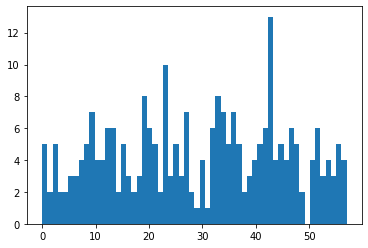

In [41]:
# check the label distribution in the batch to see if balancing was successful (note:maybe do a before and after weighing the dataloader)
import matplotlib.pyplot as plt
plt.hist(y,bins=58)

# Defining the architecture for a 1D CNN (not ResNet)

In [19]:
# monkey patch to change back tensor type
def _conv_forward(self, input: Tensor, weight: Tensor, bias: Optional[Tensor]):
    input= input.type(torch.FloatTensor).cuda() # added this line to change the tensor type
    if self.padding_mode != 'zeros':
        return F.conv1d(F.pad(input, self._reversed_padding_repeated_twice, mode=self.padding_mode),
                        weight, bias, self.stride,
                        _single(0), self.dilation, self.groups)
    return F.conv1d(input, weight, bias, self.stride,
                    self.padding, self.dilation, self.groups)
# replace in the module
nn.Conv1d._conv_forward = _conv_forward

In [20]:
# ConvLayer creates a sequence of convolutional (ni to nf), ReLU (if use_activ) and norm_type layers
def block(ni, nf): return ConvLayer(ni, nf, stride=2, ndim=1, ks=5)

In [21]:
def get_model():
    return nn.Sequential(
        block(20, 32), #how to handle this
        block(32, 64),
        block(64, 128),
        block(128, 256),
        nn.AdaptiveAvgPool1d(1),
        Flatten(),
        nn.Linear(256, 58)) 

In [30]:
# metric
#precision = Precision(average='weighted') 
# Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.
# create learn object

#learn = Learner(dls, get_model(), loss_func=nn.CrossEntropyLoss(), metrics=accuracy) # switched metric from accuracy to precision for assessing dataset balance

In [ ]:
# try with cnn learner instead
#learn = cnn_learner(dls, get_model(), loss_func=nn.CrossEntropyLoss(), pretrained = False, metrics = accuracy)

In [23]:
#learn.summary()

In [24]:
# in this cell i try to balance the training batches
# import
#from torch.utils.data.sampler import WeightedRandomSampler


# Training the 1D CNN

In [25]:
#learn.lr_find() # choose an adequate lr

In [26]:
#from fastai.callbacks import SaveModelCallback

In [27]:
# fit and train 
epochs=1
lr=0.1
learn = learn.fit_one_cycle(epochs, lr) #callbacks=[SaveModelCallback(learn, every='epoch',  monitor='accuracy', name='saved_1D_net')]) # make training more stable with fit_one_cycle

epoch,train_loss,valid_loss,accuracy,time
0,0.078036,0.079609,0.979353,12:01


In [39]:
#len(dls.train_ds)
#type(learn) # it looks like after .fit the resulting learn object is of type None for some reason. 
# i think i have to pass a parameter when creating the learner so that some stats are saved to later build the confusion matrix
#learn.dls
learn.model

Sequential(
  (0): ConvLayer(
    (0): Conv1d(20, 32, kernel_size=(5,), stride=(2,), padding=(2,), bias=False)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): ConvLayer(
    (0): Conv1d(32, 64, kernel_size=(5,), stride=(2,), padding=(2,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): ConvLayer(
    (0): Conv1d(64, 128, kernel_size=(5,), stride=(2,), padding=(2,), bias=False)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): ConvLayer(
    (0): Conv1d(128, 256, kernel_size=(5,), stride=(2,), padding=(2,), bias=False)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (4): AdaptiveAvgPool1d(output_size=1)
  (5): Flatten(full=False)
  (6): Linear(in_features=256, out_features=58, bias=True)
)

In [ ]:
# confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
#interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
interp.most_confused(min_val=100)


# Saving the 1D CNN model

In [ ]:
# save the architecture and the parameters
learn.export()

In [ ]:
# check that the file exists
path = Path()
path.ls(file_exts='.pkl')

In [ ]:
# load the model not for training but for making predictions (inference)
learn_inf = load_learner(path/'export.pkl')

In [ ]:
# make prediction
learn_inf.predict('images/grizzly.jpg') # image as example
'''returned three things: the predicted category in the same format you originally provided 
(in this case, that’s a string), the index of the predicted category, and the probabilities of each category
The last two are based on the order of categories in the vocab of the DataLoaders '''
# check vocab
learn_inf.dls.vocab
